Enter the stock ticker (e.g., AAPL): MSFT
Enter the start date (YYYY-MM-DD, e.g., 2023-01-01): 2023-01-01
Enter the end date (YYYY-MM-DD, e.g., 2024-01-01): 2024-01-01
Enter the rolling window period (e.g., 20): 20
Enter the Z-Score threshold (e.g., 2.0): 2.0


/tmp/ipython-input-660163864.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


--- Algorithmic Trading Signal Report for MSFT ---
Latest Close Price:   $371.21
Current Rolling Mean: $367.79
Current Std Dev:      $2.54
Z-Score:              1.344
Annualized Volatility: 14.67%
Relative Strength Index (RSI): 58.39
Chosen Action:        HOLD
-----------------------------------------------------


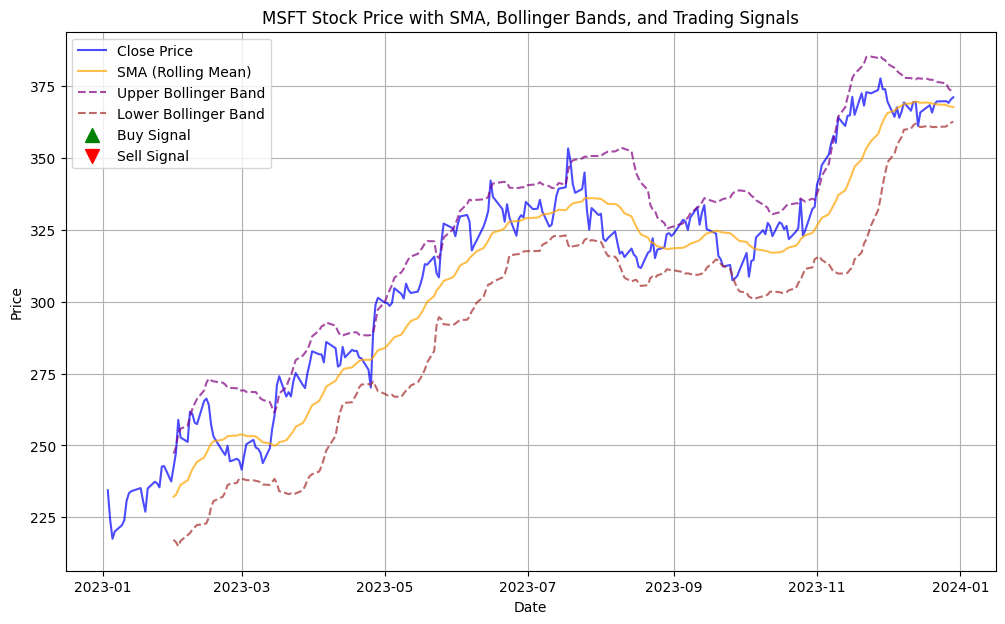

In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_data(ticker, start, end):
    try:
        data = yf.download(ticker, start=start, end=end)
        if data.empty:
            raise ValueError("No data returned from yfinance.")
        return data[['Close']]
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.DataFrame()

def calculate_rsi(data, window_val):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=window_val - 1, min_periods=window_val).mean()
    avg_loss = loss.ewm(com=window_val - 1, min_periods=window_val).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_indicators(data, window_val, z_threshold_val):
    if data.empty:
        return data

    data.loc[:, 'SMA'] = data['Close'].rolling(window=window_val).mean()
    data.loc[:, 'STD'] = data['Close'].rolling(window=window_val).std()

    # Calculate Bollinger Bands
    data.loc[:, 'Upper_Bollinger_Band'] = data['SMA'] + (z_threshold_val * data['STD'])
    data.loc[:, 'Lower_Bollinger_Band'] = data['SMA'] - (z_threshold_val * data['STD'])

    data.loc[:, 'Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data.loc[:, 'VOLATILITY'] = data['Log_Returns'].rolling(window=window_val).std() * np.sqrt(252)

    # Calculate RSI and add it to the DataFrame
    data.loc[:, 'RSI'] = calculate_rsi(data.copy(), window_val) # Pass a copy to avoid SettingWithCopyWarning

    # Convert necessary columns to NumPy arrays for calculation to avoid DataFrame issues
    # Ensure columns are float types and then convert to 1D numpy arrays
    close_np = data['Close'].astype(float).to_numpy().ravel()
    sma_np = data['SMA'].astype(float).to_numpy().ravel()
    std_np = data['STD'].astype(float).to_numpy().ravel()

    # Perform arithmetic operations using NumPy arrays
    z_score_np = (close_np - sma_np) / std_np

    # Convert the NumPy array result back to a Pandas Series, maintaining the original index
    data.loc[:, 'Z_SCORE'] = pd.Series(z_score_np, index=data.index)

    return data

def generate_signal(data, window_val, z_threshold_val):
    if data.empty or data.shape[0] < window_val:
        # Added RSI to the error return as well
        return "ERROR: Insufficient data for calculation.", 0, 0, 0, 0, 0, 0

    latest = data.iloc[-1]

    # Explicitly get the scalar values for all variables used in printing
    close_price = latest['Close'].item()
    mean_val = latest['SMA'].item()
    std_val = latest['STD'].item()
    z_score = latest['Z_SCORE'].item()
    volatility = latest['VOLATILITY'].item()
    rsi_val = latest['RSI'].item() # Get the latest RSI value

    if z_score > z_threshold_val:
        action = "SELL"
    elif z_score < -z_threshold_val:
        action = "BUY"
    else:
        action = "HOLD"

    # Return RSI_val as well
    return action, close_price, mean_val, std_val, z_score, volatility, rsi_val

def main():
    # Use input for user-adjustable parameters
    ticker_input = input("Enter the stock ticker (e.g., AAPL): ")
    start_date_input = input("Enter the start date (YYYY-MM-DD, e.g., 2023-01-01): ")
    end_date_input = input("Enter the end date (YYYY-MM-DD, e.g., 2024-01-01): ")

    try:
        window_input = int(input("Enter the rolling window period (e.g., 20): "))
        z_threshold_input = float(input("Enter the Z-Score threshold (e.g., 2.0): "))
    except ValueError:
        print("Invalid input for window or Z-threshold. Please enter numeric values.")
        return

    data = get_data(ticker_input, start_date_input, end_date_input)

    if data.empty:
        print("Could not retrieve data. Exiting.")
        return

    # Updated call to calculate_indicators with z_threshold_input
    processed_data = calculate_indicators(data, window_input, z_threshold_input)

    # Initialize Buy and Sell signal columns with NaN
    processed_data['Buy_Signal'] = np.nan
    processed_data['Sell_Signal'] = np.nan

    # Assign values conditionally using .loc for robustness
    processed_data.loc[processed_data['Z_SCORE'] < -z_threshold_input, 'Buy_Signal'] = processed_data['Close']
    processed_data.loc[processed_data['Z_SCORE'] > z_threshold_input, 'Sell_Signal'] = processed_data['Close']

    signal, price, mean, std, zscore, vol, rsi = generate_signal(processed_data, window_input, z_threshold_input)

    print(f"--- Algorithmic Trading Signal Report for {ticker_input} ---")
    print(f"Latest Close Price:   ${price:,.2f}")
    print(f"Current Rolling Mean: ${mean:,.2f}")
    print(f"Current Std Dev:      ${std:,.2f}")
    print(f"Z-Score:              {zscore:.3f}")
    print(f"Annualized Volatility: {vol*100:,.2f}%")
    print(f"Relative Strength Index (RSI): {rsi:.2f}") # Print RSI
    print(f"Chosen Action:        {signal}")
    print("-----------------------------------------------------")

    # Plotting
    plt.figure(figsize=(12, 7))
    plt.plot(processed_data.index, processed_data['Close'], label='Close Price', color='blue', alpha=0.7)
    plt.plot(processed_data.index, processed_data['SMA'], label='SMA (Rolling Mean)', color='orange', alpha=0.7)
    # Plot Bollinger Bands
    plt.plot(processed_data.index, processed_data['Upper_Bollinger_Band'], label='Upper Bollinger Band', color='purple', linestyle='--', alpha=0.7)
    plt.plot(processed_data.index, processed_data['Lower_Bollinger_Band'], label='Lower Bollinger Band', color='brown', linestyle='--', alpha=0.7)

    plt.scatter(processed_data.index, processed_data['Buy_Signal'], label='Buy Signal', marker='^', color='green', s=100)
    plt.scatter(processed_data.index, processed_data['Sell_Signal'], label='Sell Signal', marker='v', color='red', s=100)

    plt.title(f'{ticker_input} Stock Price with SMA, Bollinger Bands, and Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()